In [1]:
data_path = "../data/annotated_data"
save_model_dir_name = "best_model_albert"
# set to true if colab!
colab = False
train_model = False
if colab:
    data_path = '/content/drive/MyDrive/annotated_data'
    !pip install transformers
    !pip install evaluate
    !pip install seaborn
    !pip install accelerate
    !pip install Cython
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except:
        print("probably not in colab")

# Imports

In [2]:
import os
import ast
import json
import torch
torch.manual_seed(0)
import random
random.seed(0)
import itertools
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AlbertForSequenceClassification,get_scheduler
from sklearn import preprocessing
from tqdm.auto import tqdm
from experiment_utils import EarlyStopper
from sklearn.metrics import accuracy_score, classification_report

# Load Data

In [3]:
files = [f for f in os.listdir(data_path) if f.endswith('jsonl')]
rows = []

In [4]:
for f in files:
    with open(f'{data_path}/{f}', 'r') as json_file:
        json_list = list(json_file)
    for json_str in json_list:
        result = json.loads(json_str)
        label = result["label"]
        text = result["text"]
        new_spans = []
        if result["spans"] and len(result["spans"]) != 0:
            try:
                new_spans = [s["text"] for s in result["spans"]]
            except:
                x = ast.literal_eval(result["spans"])
                new_spans = [s["text"] for s in x]
        new_row = {
            "text":text,
            "label":label,
            "spans":new_spans
        }
        rows.append(new_row)
    print(f"Loaded: {f}")
df = pd.DataFrame(rows)

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


## Inspecting the data

Text(0.5, 1.0, 'number of examples per class')

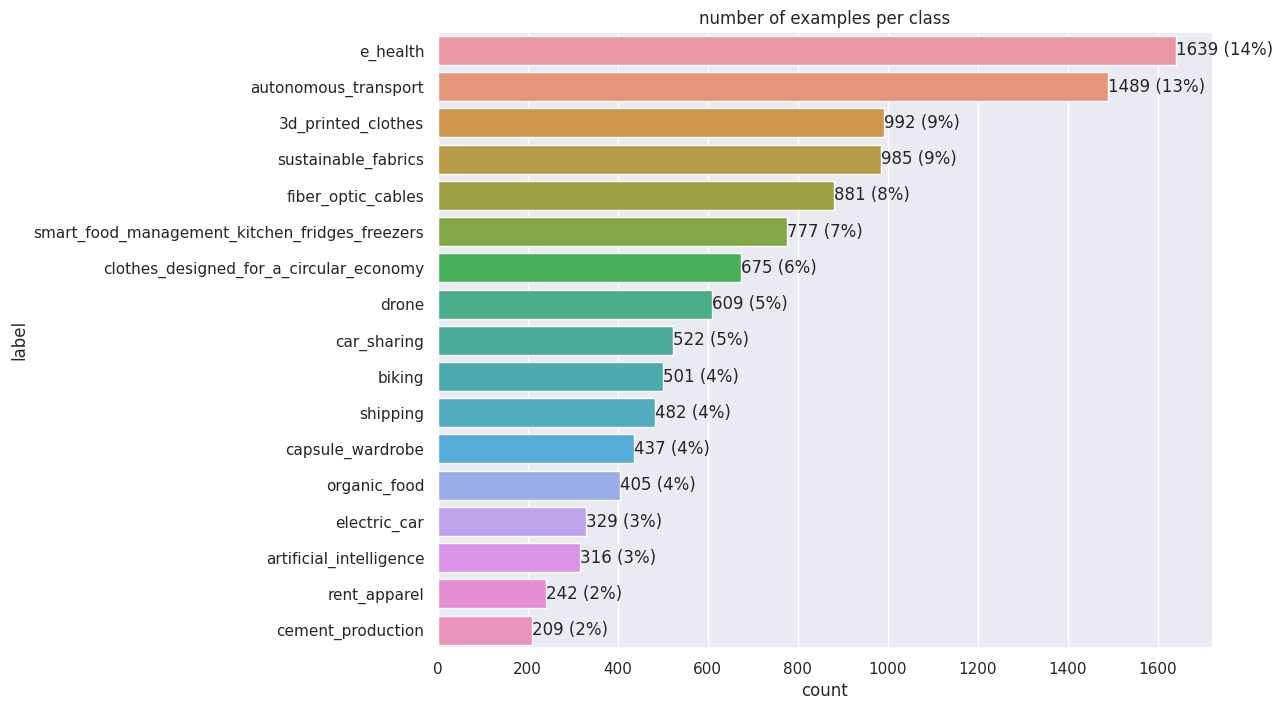

In [5]:
plt.figure(figsize=(10,8))

abs_values = df['label'].value_counts(ascending=False)
g = sns.countplot(data=df, y="label", order=abs_values.index)
rel_values = df['label'].value_counts(ascending=False, normalize=True).values * 100
bar_labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values.values, rel_values)]
g.bar_label(container=g.containers[0], labels=bar_labels)
g.set_title("number of examples per class")

text length statistics


,mean,median,min,max
label,,,,
3d_printed_clothes,383.121976,380.5,57,1054
artificial_intelligence,470.534810,458.0,184,952
autonomous_transport,415.642042,403.0,14,2315
biking,419.335329,409.0,112,1187
capsule_wardrobe,358.945080,321.0,73,1189
car_sharing,318.021073,311.0,16,848
cement_production,450.602871,439.0,35,1119
clothes_designed_for_a_circular_economy,432.047407,414.0,123,1195
drone,410.180624,412.0,16,1655


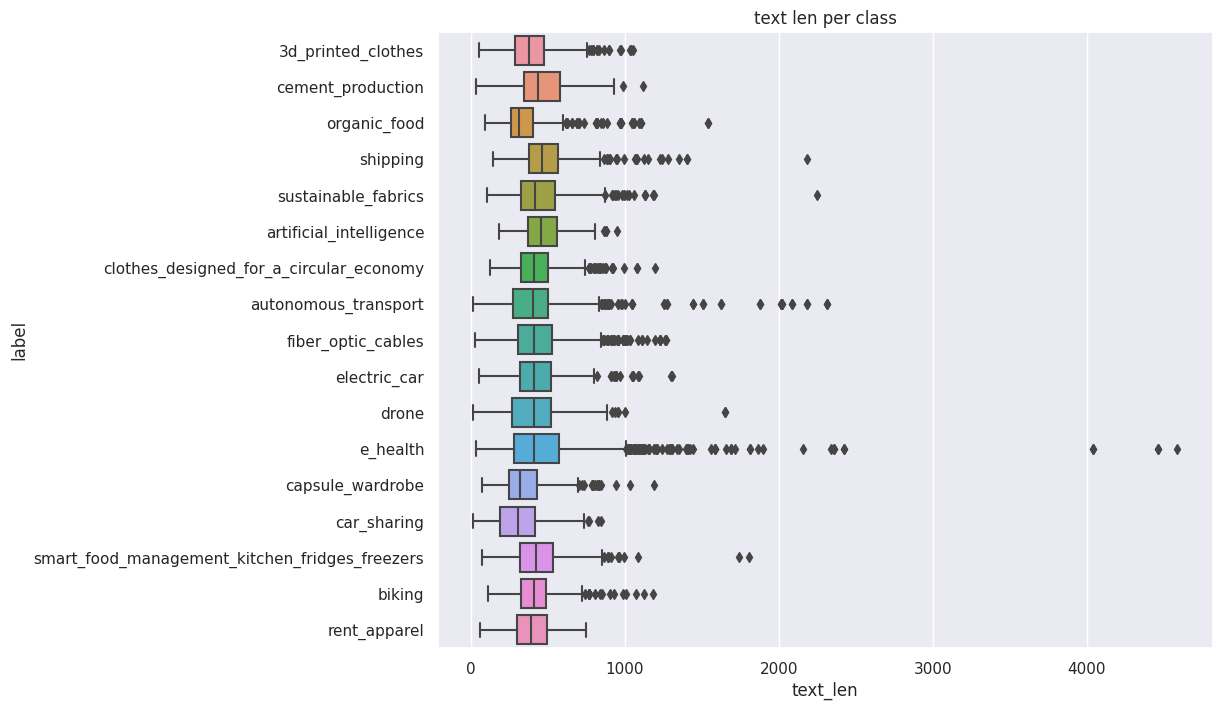

In [6]:
df["text_len"] = df[["text"]].apply(lambda x:len(x.item()), axis=1)
plt.figure(figsize=(10,8))
g = sns.boxplot(data=df, x="text_len", y="label")
g.set_title("text len per class")
print("text length statistics")
df.groupby(["label"])["text_len"].agg(["mean","median","min","max"])

# Data Preparation
## Encode Labels

In [7]:
le = preprocessing.LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

## Train, Valdiation and Test Split

In [8]:
# 70, 20, 10 split
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [9]:
# collect spans from the training data-set
new_spans = set(itertools.chain.from_iterable(train_df.spans.tolist()))

# Create Datasets and Tokenize

In [10]:
# add new spans to the tokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2", do_lower_case=False)
# extend tokenizer with domain spans
new_tokens = set(new_spans) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(new_tokens))

295

In [11]:
# define PyTorch dataset
class TAndIDataSet(Dataset):
    def __init__(self, text_column, encoded_labels):
        self.texts = text_column
        self.encodings = tokenizer(text_column.tolist(), truncation=True, padding=True, max_length=512)
        self.labels = encoded_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item, self.texts[idx]

    def __len__(self):
        return len(self.labels)

In [12]:
# create datasets
train_dataset = TAndIDataSet(train_df.text, train_df.label_encoded)
val_dataset = TAndIDataSet(val_df.text, val_df.label_encoded)
test_dataset = TAndIDataSet(test_df.text, test_df.label_encoded)
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader =  DataLoader(test_dataset, batch_size=4)

# Finetuning
## Definitions

In [13]:
if train_model:
    # model definition
    model = AlbertForSequenceClassification.from_pretrained(
        "albert-base-v2",
        num_labels=len(le.classes_)
    ).to("cuda")
    # adjust embeddings size for new vocabulary length
    model.resize_token_embeddings(len(tokenizer))
else:
    tokenizer = AutoTokenizer.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True)
    model = AlbertForSequenceClassification.from_pretrained(f"./model_checkpoints/{save_model_dir_name}", local_files_only=True).to("cuda")

In [14]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# epochs
num_epochs = 15
# learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader)
)

## Training Loop

In [15]:
if train_model:
    training_stats = []
    progress_bar = tqdm(range(num_epochs*(len(train_dataloader)+len(val_dataloader))))
    early_stopper = EarlyStopper(patience=5)
    for epoch in range(num_epochs):
        print(f"\nRunning Epoch {epoch+1}/{num_epochs}...")
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_train_correct = 0
        epoch_val_correct = 0
        best_val_loss = np.Inf
        # training loop
        model.train()
        for batch, _ in train_dataloader:
            # move batch to gpu
            batch = {k: v.to("cuda") for k, v in batch.items()}
            # forward pass
            output = model(**batch)
            predictions = torch.argmax(output.logits, dim=-1)
            epoch_train_correct += (predictions == batch["labels"].flatten()).long().sum()
            # compute loss & backprop
            loss = output.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # reset optimizer
            optimizer.zero_grad()
            # save batch_loss
            epoch_train_losses.append(loss.item())
            progress_bar.update(1)
        # validation loop
        model.eval()
        for batch, _ in val_dataloader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            with torch.no_grad():
                output = model(**batch)
                predictions = torch.argmax(output.logits, dim=-1)
                epoch_val_correct += (predictions == batch["labels"].flatten()).long().sum()
                epoch_val_losses.append(output.loss.item())
            progress_bar.update(1)
        # save epoch metrics
        mean_epoch_val_loss = np.mean(epoch_val_losses)
        epoch_stats = {
            "epoch":epoch,
            "train_loss":np.mean(epoch_train_losses),
            "val_loss":mean_epoch_val_loss,
            "train_accuracy":epoch_train_correct.item()/len(train_dataset),
            "val_accuracy":epoch_val_correct.item()/len(val_dataset)
        }
        print(epoch_stats)
        training_stats.append(epoch_stats)
        # save best model
        if mean_epoch_val_loss < best_val_loss:
            model_path = f"./{save_model_dir_name}"
            model.save_pretrained(model_path)
            tokenizer.save_pretrained(model_path)
            best_val_loss = mean_epoch_val_loss

        if early_stopper.early_stop(mean_epoch_val_loss):
            print("Stopping early")
            break

    # if colab make sure to save best model to google drive
    training_stats = pd.DataFrame(training_stats)
    if colab:
        !cp -r $save_model_dir_name /content/drive/MyDrive
else:
    print("training disabled")

training disabled


In [16]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_loss","val_loss"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

In [17]:
if train_model:
    plt.figure(figsize=(8,8))
    sns.lineplot(
        data=training_stats[["epoch","train_accuracy","val_accuracy"]].melt(id_vars=["epoch"]),
        x="epoch",
        y="value",
        hue="variable"
    )

# Testing

In [18]:
progress_bar = tqdm(range(len(test_dataloader)))
test_correct = 0
test_predictions = []
model.eval()
softmax = torch.nn.Softmax(dim=len(le.classes_))
for batch, texts in test_dataloader:
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        output = model(**batch, output_attentions=True, output_hidden_states=True)
        local_predictions = torch.argmax(output.logits, dim=-1)
        top_k_predictions = torch.topk(output.logits, k=3)
        test_correct += (local_predictions == batch["labels"].flatten()).long().sum()
        for idx, pred in enumerate(local_predictions.tolist()):
            test_predictions.append({
                "y_hat_enc":pred,
                "y_enc":batch["labels"].flatten().tolist()[idx],
                "text":texts[idx],
                "top_k":top_k_predictions.indices[idx].tolist(),
                "top_k_logits": top_k_predictions.values[idx].tolist(),
                "in_top_k":batch["labels"].flatten().tolist()[idx] in top_k_predictions.indices[idx].tolist()
            })
    progress_bar.update(1)
print(f"Test Accuracy: {test_correct/(len(test_dataloader)*test_dataloader.batch_size)}")
test_predictions = pd.DataFrame(test_predictions)
test_predictions["y"] = le.inverse_transform(test_predictions["y_enc"])
test_predictions["y_hat"] = le.inverse_transform(test_predictions["y_hat_enc"])
print(f"Test top-k Accuracy: {len(test_predictions.loc[test_predictions.in_top_k])/(len(test_dataloader)*test_dataloader.batch_size)}")

  0%|          | 0/288 [00:00<?, ?it/s]

Test Accuracy: 0.8576388955116272
Test top-k Accuracy: 0.9305555555555556


## Wrong classifications

In [19]:
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].head(n=1000)

,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
15,14,8,The policy paper pleads for ethical agreements...,"[14, 8, 1]","[4.098049163818359, 3.3272781372070312, 3.2120...",True,drone,shipping
25,7,2,Autonomous Solutions\nWe develop commercially ...,"[7, 16, 14]","[6.955501556396484, 2.4238827228546143, 2.1137...",False,autonomous_transport,clothes_designed_for_a_circular_economy
41,0,11,"21. Also, theoretical output, which is based o...","[0, 11, 2]","[6.911341190338135, 5.75344181060791, 0.187461...",True,fiber_optic_cables,3d_printed_clothes
51,14,8,“We can cost-effectively eliminate violations ...,"[14, 8, 2]","[7.660602569580078, 4.717797756195068, 0.71371...",True,drone,shipping
53,5,16,There are a lot of sustainable materials that ...,"[5, 10, 6]","[5.19348669052124, 2.8180549144744873, 0.81667...",False,sustainable_fabrics,car_sharing
...,...,...,...,...,...,...,...,...
1107,14,2,Google has been an important entrepreneur that...,"[14, 2, 10]","[7.089824199676514, 2.110128402709961, 1.85557...",True,autonomous_transport,shipping
1125,4,16,By seeking information about the people who ma...,"[4, 13, 15]","[7.893500328063965, 2.1336159706115723, 1.3251...",False,sustainable_fabrics,capsule_wardrobe
1127,1,8,"If you're thinking of apiculture, you might b...","[1, 14, 2]","[6.544695854187012, 3.337247848510742, 0.99844...",False,drone,artificial_intelligence
1134,11,16,"It is also biodegradable, which is a huge plus...","[11, 6, 10]","[8.671887397766113, 1.74009108543396, 1.260453...",False,sustainable_fabrics,fiber_optic_cables


In [20]:
print("num. miss-classifications per class")
test_predictions.loc[test_predictions.y_enc != test_predictions.y_hat_enc].groupby(["y"])["y"].count()

num. miss-classifications per class


y
3d_printed_clothes                                14
artificial_intelligence                            3
autonomous_transport                              12
biking                                            25
capsule_wardrobe                                   2
car_sharing                                        3
cement_production                                  3
clothes_designed_for_a_circular_economy           13
drone                                             35
e_health                                          13
electric_car                                       6
fiber_optic_cables                                 3
organic_food                                       3
shipping                                           5
smart_food_management_kitchen_fridges_freezers     3
sustainable_fabrics                               18
Name: y, dtype: int64

### Confusion Matrix

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics
                                                precision    recall  f1-score   support

                            3d_printed_clothes       0.93      0.85      0.89        93
                       artificial_intelligence       0.61      0.92      0.73        36
                          autonomous_transport       0.93      0.92      0.92       144
                                        biking       0.93      0.50      0.65        50
                              capsule_wardrobe       0.84      0.96      0.90        49
                                   car_sharing       0.81      0.93      0.87        42
 

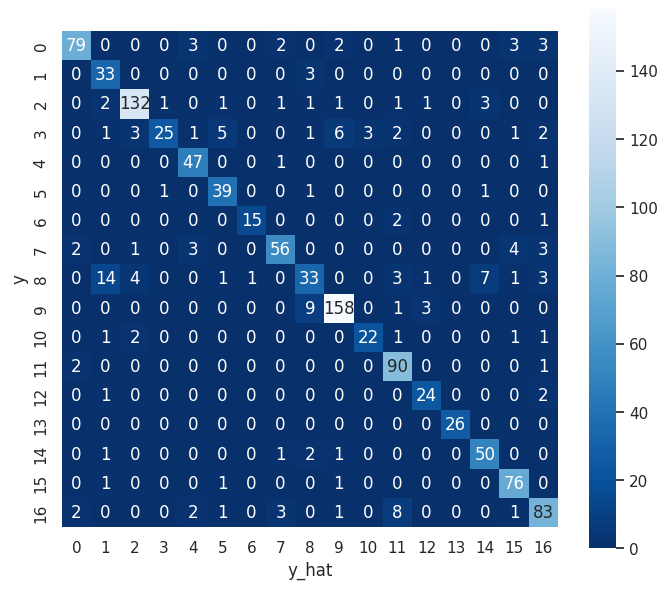

In [27]:
# axis_ticks = le.inverse_transform(list(range(0,17)))
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
cm = confusion_matrix(test_predictions["y_enc"],test_predictions["y_hat_enc"])
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g', square = True, cmap = 'Blues_r')
g.set_ylabel("y")
g.set_xlabel("y_hat")

print(classification_report(test_predictions["y_enc"],test_predictions["y_hat_enc"], target_names=le.classes_))
print("Accuracy score: ", accuracy_score(test_predictions["y_enc"],test_predictions["y_hat_enc"]))
per_class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("per class accuracy:", per_class_accuracy)

### Detailed inspection of miss-classifications

In [22]:
# class of interest
coi = "electric_car"
coi_miss = test_predictions.loc[(test_predictions.y==coi) & (test_predictions.y_hat != coi)]
print(f"Total num. miss: {len(coi_miss)}, non-top-k miss: {len(coi_miss.loc[~coi_miss.in_top_k])}")
coi_miss_enhanced = []
for idx, row in coi_miss.iterrows():
    for tk in range(len(row.top_k)):
        new_row = {
            "score": row.top_k_logits[tk],
            "y_hat_enc": row.top_k[tk],
            "y_hat": le.inverse_transform([row.top_k[tk]])[0],
            "rank":str(tk)
        }
        coi_miss_enhanced.append(new_row)
coi_miss_enhanced = pd.DataFrame(coi_miss_enhanced)
coi_miss

Total num. miss: 6, non-top-k miss: 5


,y_hat_enc,y_enc,text,top_k,top_k_logits,in_top_k,y,y_hat
187,2,10,Virtual Fixit Clinic\nAs COVID-19 unfolds Fixi...,"[2, 9, 5]","[2.978508949279785, 2.5101609230041504, 1.6028...",False,electric_car,autonomous_transport
410,1,10,"Similarly, rebate recipients place great value...","[1, 16, 2]","[5.552404880523682, 3.472846746444702, 1.89732...",False,electric_car,artificial_intelligence
666,11,10,"Electric vehicles can also bring down noise, e...","[11, 1, 8]","[3.792153835296631, 3.6919338703155518, 2.8503...",False,electric_car,fiber_optic_cables
820,15,10,"Do something for our planet, print this page o...","[15, 11, 12]","[8.36622142791748, 2.065091133117676, 0.724086...",False,electric_car,smart_food_management_kitchen_fridges_freezers
863,2,10,Is there a way to ensure a smoother ride for n...,"[2, 3, 10]","[5.12415885925293, 3.3663415908813477, 2.20845...",True,electric_car,autonomous_transport
1037,16,10,"In terms of maintenance, you save on oil and l...","[16, 11, 1]","[7.503574848175049, 1.695771336555481, 1.03133...",False,electric_car,sustainable_fabrics


rank 0 should be 'electric_car'


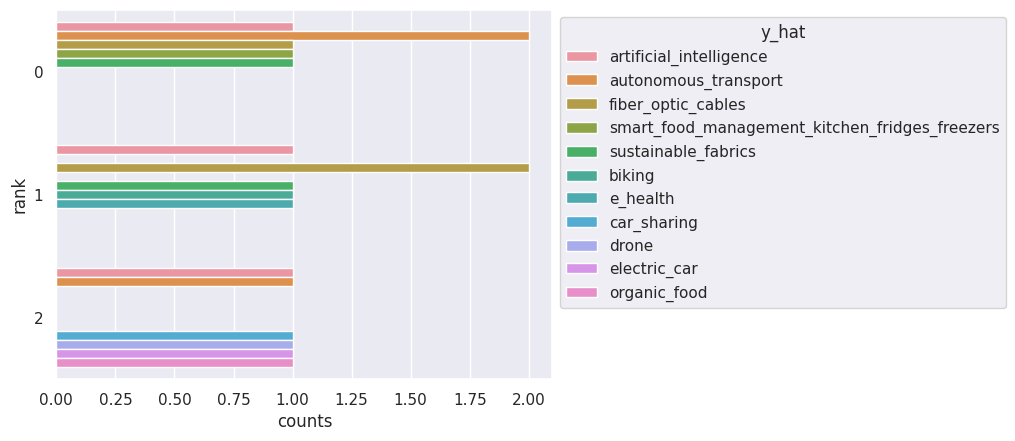

In [23]:
print(f"rank 0 should be '{coi}'")
coi_miss_enhanced_agg = coi_miss_enhanced.groupby(['rank',"y_hat","y_hat_enc"]).size().reset_index(name="counts")
g = sns.barplot(data=coi_miss_enhanced_agg, y="rank", x="counts", hue="y_hat")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

#### Inspecting text of non top-k correct classifications

0 : 3d_printed_clothes
1 : artificial_intelligence
2 : autonomous_transport
3 : biking
4 : capsule_wardrobe
5 : car_sharing
6 : cement_production
7 : clothes_designed_for_a_circular_economy
8 : drone
9 : e_health
10 : electric_car
11 : fiber_optic_cables
12 : organic_food
13 : rent_apparel
14 : shipping
15 : smart_food_management_kitchen_fridges_freezers
16 : sustainable_fabrics
Num of non-top-k predictions: 77


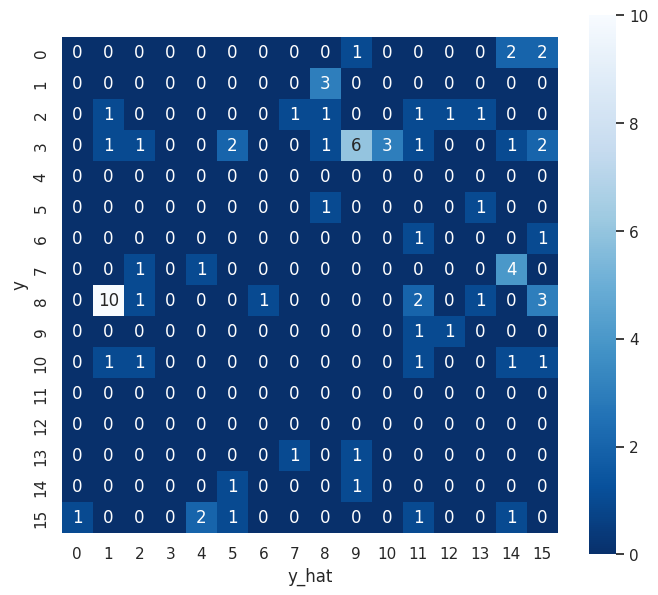

In [24]:
non_top_k = test_predictions.loc[~test_predictions.in_top_k]
#axis_ticks = le.inverse_transform(list(set(list(non_top_k.y_hat_enc.unique()) + list(non_top_k.y_enc.unique()))))
cm = confusion_matrix(non_top_k["y_enc"],non_top_k["y_hat_enc"])
for key,value in le_name_mapping.items():
    print(f"{value} : {key}")
plt.figure(figsize=(8,7))
g = sns.heatmap(cm, annot=True, fmt='g', square = True, cmap = 'Blues_r')
g.set_ylabel("y")
g.set_xlabel("y_hat")
print(f"Num of non-top-k predictions: {len(non_top_k)}")

In [28]:
# subselect worst class
for idx, row in non_top_k.loc[non_top_k.y == "drone"].iterrows():
    print(f"[{idx}]")
    print(f"class: {row.y}, predicted: {row.y_hat}")
    print(row.text)
    print("--------------")

[69]
class: drone, predicted: sustainable_fabrics
5) Agricultural sustainability solutions
Drones are gradually replacing more gas-guzzling machines on farms and agricultural land. UAVs can become precision agricultural instruments, spraying plants in such a way that it reduces fertiliser use by 20% - conserving an important hydrocarbon-infused resource, and protecting the environment from pollution in the process. UAV are also now becoming an invaluable tool by farmers in other aspect of farming, such as monitoring livestock, crops and water levels.
--------------
[90]
class: drone, predicted: artificial_intelligence
Here, too, drone technology can help with projects and initiatives being developed that, in some instances, see drones act in a kind of 'first responder' role.. With a carbon-fibre cage surrounding it, the Gimball drone is able to bounce against objects such as walls. The drone can approach disaster zones very closely and find missing people, buried under debris after a c